Using LSTM to predict stock price.

Source:https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
Source: https://www.kaggle.com/rodsaldanha/stock-prediction-pytorch/data

In [71]:
import numpy as np
import pandas as pd
import os

In [72]:
# Selecting RELIANCE stock 

filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [73]:
print("number of entrie", len(data))

number of entrie 2895


In [74]:
data.shape

(2895, 7)

In [75]:
# Importing visualisation libraries. Seaborn is visualisation library for matplotlib.
import matplotlib.pyplot as plt
import seaborn as sns

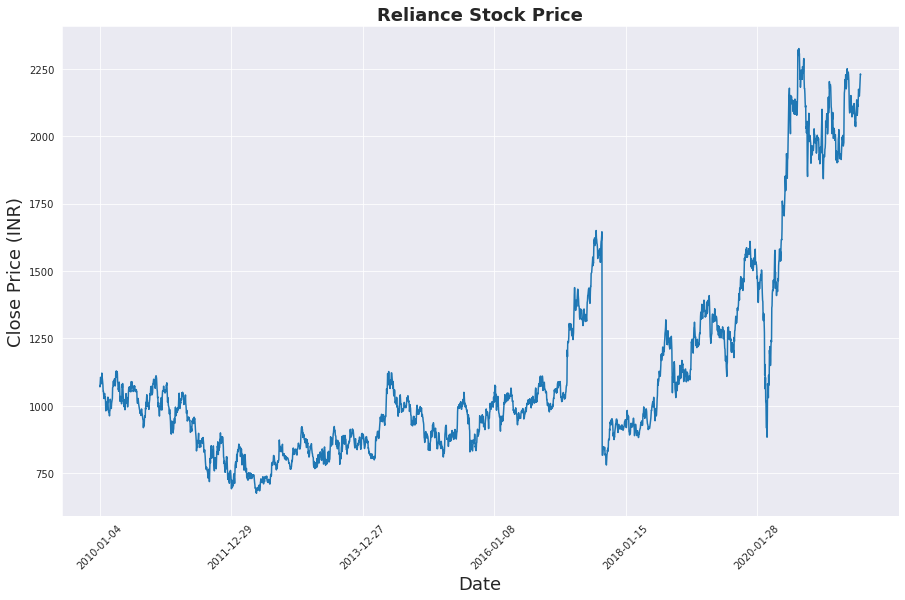

In [76]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Reliance Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

Normalize data

In [77]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2895 entries, 0 to 2894
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2895 non-null   float64
dtypes: float64(1)
memory usage: 45.2 KB


In [78]:
price.head()

,Close
0,1075.50
1,1070.70
2,1088.00
3,1106.05
4,1103.15


In [79]:
from sklearn.preprocessing import MinMaxScaler

In [80]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/home/ambekar/anaconda3/envs/safeml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
price.head()

,Close
0,-0.515424
1,-0.521247
2,-0.500258
3,-0.478358
4,-0.481877


In [82]:
def split_data(stock, window_sz):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - window_sz): 
        data.append(data_raw[index: index + window_sz])
        # print(data)
        
    
    data = np.array(data);
    # print("data shape", data.shape)
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [83]:
window_sz = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, window_sz)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2300, 19, 1)
y_train.shape =  (2300, 1)
x_test.shape =  (575, 19, 1)
y_test.shape =  (575, 1)


In [1]:
import torch
import torch.nn as nn

print("GPU available:", torch.cuda.is_available())

GPU available: True


In [85]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [86]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [87]:
from Models import LSTM
import time

In [88]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [89]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4023263454437256
Epoch  1 MSE:  0.23252716660499573
Epoch  2 MSE:  0.07643374055624008
Epoch  3 MSE:  0.13913552463054657
Epoch  4 MSE:  0.06066780537366867
Epoch  5 MSE:  0.03966505452990532
Epoch  6 MSE:  0.05060664936900139
Epoch  7 MSE:  0.06015753000974655
Epoch  8 MSE:  0.061935875564813614
Epoch  9 MSE:  0.0574001744389534
Epoch  10 MSE:  0.04971635714173317
Epoch  11 MSE:  0.04223493114113808
Epoch  12 MSE:  0.037763576954603195
Epoch  13 MSE:  0.03764631971716881
Epoch  14 MSE:  0.04087762534618378
Epoch  15 MSE:  0.04439381882548332
Epoch  16 MSE:  0.04527152329683304
Epoch  17 MSE:  0.04301343485713005
Epoch  18 MSE:  0.039358168840408325
Epoch  19 MSE:  0.0363691970705986
Epoch  20 MSE:  0.035059262067079544
Epoch  21 MSE:  0.03526429831981659
Epoch  22 MSE:  0.03618708252906799
Epoch  23 MSE:  0.03696350380778313
Epoch  24 MSE:  0.037000954151153564
Epoch  25 MSE:  0.03610070422291756
Epoch  26 MSE:  0.0344415009021759
Epoch  27 MSE:  0.03247709572315216
E

In [90]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, '')]

<Figure size 432x288 with 0 Axes>

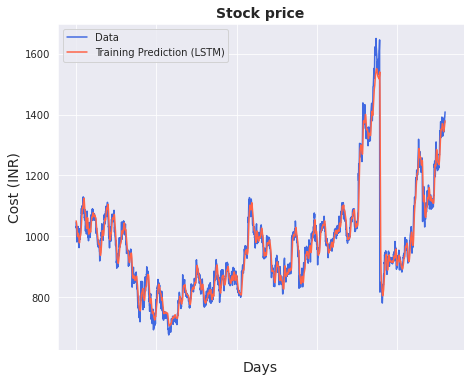

In [91]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (INR)", size = 14)
ax.set_xticklabels('', size=10)

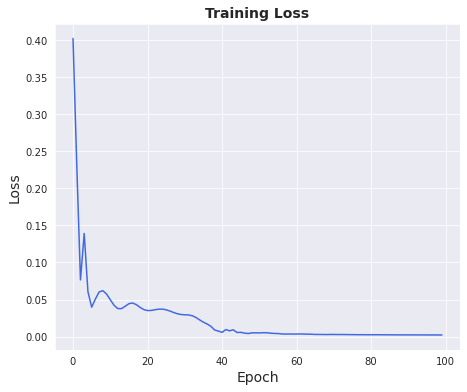

In [92]:
plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(20)
plt.show()

In [93]:
import math
from sklearn.metrics import mean_squared_error

In [94]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 37.96 RMSE
Test Score: 271.06 RMSE


In [95]:
from sklearn.metrics import r2_score
print(f'R-squared value is {r2_score(y_test, y_test_pred)}')
lstm.append(r2_score(y_test, y_test_pred))

R-squared value is 0.46048430025027454


In [96]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_sz:len(y_train_pred)+window_sz, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+window_sz-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [97]:
import plotly.express as px
import plotly.graph_objects as go

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (INR)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [99]:
# import chart_studio.plotly as py
# import chart_studio

In [100]:
## This is currently not supported. As this requires signup and API key.

#chart_studio.tools.set_credentials_file(username='rodolfo_saldanha', api_key='zWJIVWJs23wfiAp516Mh')
#py.iplot(fig, filename='stock_prediction_lstm')

In [101]:
from Models import GRU

In [102]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [103]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6469494700431824
Epoch  1 MSE:  0.26217028498649597
Epoch  2 MSE:  0.030311690643429756
Epoch  3 MSE:  0.22516117990016937
Epoch  4 MSE:  0.10376384854316711
Epoch  5 MSE:  0.023279909044504166
Epoch  6 MSE:  0.04000826179981232
Epoch  7 MSE:  0.07211800664663315
Epoch  8 MSE:  0.0833294615149498
Epoch  9 MSE:  0.07439986616373062
Epoch  10 MSE:  0.05537046864628792
Epoch  11 MSE:  0.0359787717461586
Epoch  12 MSE:  0.0234002023935318
Epoch  13 MSE:  0.02097138576209545
Epoch  14 MSE:  0.026896975934505463
Epoch  15 MSE:  0.03472435846924782
Epoch  16 MSE:  0.0375085212290287
Epoch  17 MSE:  0.033048294484615326
Epoch  18 MSE:  0.024737786501646042
Epoch  19 MSE:  0.017776664346456528
Epoch  20 MSE:  0.015239045955240726
Epoch  21 MSE:  0.016834255307912827
Epoch  22 MSE:  0.019973240792751312
Epoch  23 MSE:  0.021682534366846085
Epoch  24 MSE:  0.020261121913790703
Epoch  25 MSE:  0.016044078394770622
Epoch  26 MSE:  0.011081899516284466
Epoch  27 MSE:  0.007910906337

In [104]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

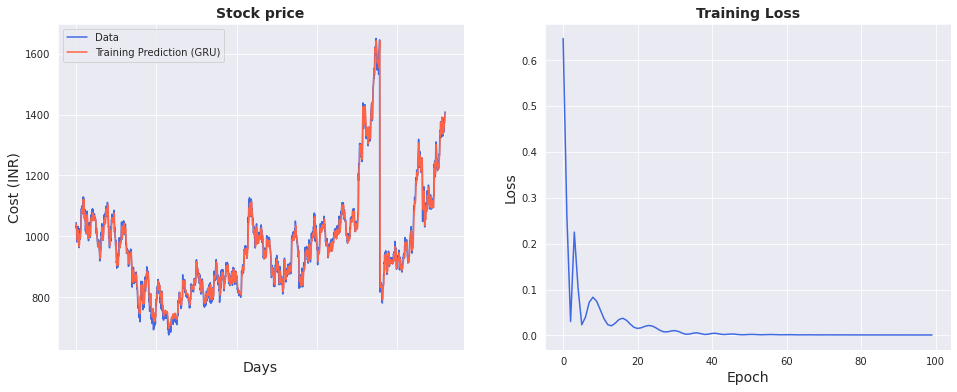

In [105]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (INR)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

plt.show()

In [106]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 26.30 RMSE
Test Score: 52.94 RMSE


In [107]:
from sklearn.metrics import r2_score
print(f'R-squared value is {r2_score(y_test, y_test_pred)}')

gru.append(r2_score(y_test, y_test_pred))

R-squared value is 0.9794203582445625


In [108]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_sz:len(y_train_pred)+window_sz, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+window_sz-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [109]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (INR)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [110]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time', 'R2 score']
result

,LSTM,GRU
Train RMSE,37.959805,26.295696
Test RMSE,271.056440,52.939105
Train Time,7.020847,5.106954
R2 score,0.460484,0.979420


In [111]:
# THIS is not supported yet. 
#py.iplot(fig, filename='stock_prediction_gru')